# Stage 5 — Rebalancing & Backtesting

This notebook:
- Loads `data/price_data.csv`, model artifacts and optimized weights.
- Simulates a portfolio that is rebalanced periodically (monthly by default).
- Accounts for turnover and transaction costs.
- Computes performance (cumulative returns, CAGR, volatility, Sharpe, max drawdown) and turnover.
- Compares to benchmarks: Equal Weight and Minimum Variance (if covariance available).
- Saves summary and plots to `results/backtest/`.

Assumptions:
- `data/price_data.csv` has columns: `date`, `ticker`, `close_price`.
- Optimized weights are available either as:
  - multiple files in `results/portfolios/` named like `optimized_weights_YYYY-MM-DD.csv` (cols: date,ticker,weight), or
  - a single CSV `results/portfolios/optimized_weights.csv` with columns (date,ticker,weight).
- `results/volatility_matrix.csv` may contain covariance info (optional).


Setups and imports

In [1]:
# Cell 1: Setup & imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import datetime as dt

# Basic plotting settings
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.dpi'] = 120

# === CONFIG ===
PROJECT_ROOT = Path(r"D:\Portfolio Optimzation project")  # adjust if needed
DATA_DIR = PROJECT_ROOT / "data"
RESULTS_DIR = PROJECT_ROOT / "results"
PORTFOLIO_DIR = RESULTS_DIR / "portfolios"
BACKTEST_DIR = RESULTS_DIR / "backtest"
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
VOL_FILE = RESULTS_DIR / "volatility_matrix.csv"  # optional covariance/vol file
ALPHA_FILE = ARTIFACTS_DIR / "alpha_predictions.csv"

os.makedirs(BACKTEST_DIR, exist_ok=True)

# Parameters
REB_FREQ = 'monthly'                # 'monthly' | 'weekly' | 'quarterly'
INITIAL_CAPITAL = 1_000_000.0
TRANSACTION_COST = 0.001            # fraction per turnover (0.001 == 0.1%)
RISK_FREE_ANNUAL = 0.05             # 5% p.a.
TRADING_DAYS_PER_YEAR = 252
RISK_FREE_DAILY = RISK_FREE_ANNUAL / TRADING_DAYS_PER_YEAR


Cell 2 — Load price_data and pivot to panel (close)

In [2]:
# Cell 2: Load prices and pivot to wide panel
price_file = DATA_DIR / "price_data.csv"
assert price_file.exists(), f"{price_file} not found. Place price_data.csv in {DATA_DIR}"

price_df = pd.read_csv(price_file, parse_dates=['date'])
# Remove timezone to simplify arithmetic (optional)
price_df['date'] = pd.to_datetime(price_df['date']).dt.tz_localize(None)

# keep required columns and rename if necessary
price_df = price_df.rename(columns={'close_price': 'close'})[['date', 'ticker', 'close']]

# pivot to wide (dates x tickers)
price_wide = price_df.pivot(index='date', columns='ticker', values='close').sort_index()
price_wide = price_wide.sort_index()
print("Price panel shape:", price_wide.shape)
price_wide.head()
# randomly show few rows and columns
# price_wide.sample(5, axis=0).sample(5, axis=1)  # 5 random dates and 5 random tickers

# % of  missing data per ticker
# missing_pct = price_wide.isna().mean() * 100
# print("Missing data percentage per ticker:")
# print(missing_pct[missing_pct > 0])  # only show tickers with missing data

missing_ratio = price_wide.isna().mean().sort_values(ascending=False)
print(f"Tickers sorted by missing data ratio (top 10):\n{missing_ratio.head(10)}")

# Handling missing data: forward-fill, then back-fill and drop illiquid tickers(>40% missing)
threshold = 0.4
valid_tickers = missing_ratio[missing_ratio <= threshold].index
price_wide = price_wide[valid_tickers]
price_wide = price_wide.ffill().bfill()
print("After cleaning, price panel shape:", price_wide.shape)
price_wide.head()
# randomly show few rows and columns
price_wide.sample(5, axis=0).sample(5, axis=1)  # 5 random dates and 5 random tickers
# Verify no missing data remains
assert not price_wide.isna().any().any(), "Missing data remains after cleaning!"
print("No missing data remains after cleaning.")



Price panel shape: (2592, 497)
Tickers sorted by missing data ratio (top 10):
ticker
IGIL_DAILY         0.935185
IKS_DAILY          0.934799
SAILIFE_DAILY      0.934414
VMM_DAILY          0.934414
NTPCGREEN_DAILY    0.928627
NIVABUPA_DAILY     0.925926
ACMESOLAR_DAILY    0.925540
SWIGGY_DAILY       0.925540
SAGILITY_DAILY     0.925154
AFCONS_DAILY       0.922840
dtype: float64
After cleaning, price panel shape: (2592, 398)
No missing data remains after cleaning.


Cell 3 — Read optimized weights

In [3]:
# Cell 3 (updated): Load optimized weights with flexible column mapping

def load_custom_weights(file_path, weight_column):
    """Load weights from your optimized_weights.csv with specified column"""
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.lower()

    # sanity check
    required_cols = {'date', 'ticker', weight_column}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"{file_path.name} missing required columns {required_cols}")

    df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
    df = df.rename(columns={weight_column: 'weight'})
    df = df[['date', 'ticker', 'weight']]
    
    weights_by_date = {}
    for d, sub in df.groupby('date'):
        weights_by_date[pd.to_datetime(d)] = sub.set_index('ticker')['weight'].astype(float)
    return weights_by_date


# === MAIN LOADER LOGIC ===

weights_by_date = {}

opt_weights_file = PORTFOLIO_DIR / "optimized_weights.csv"

if opt_weights_file.exists():
    # your file has columns: ['date','ticker','predicted_return','volatility','w_mvo_best_sharpe','w_minvar']
    print("✅ Found optimized_weights.csv")
    print("Available columns:", list(pd.read_csv(opt_weights_file, nrows=0).columns))
    
    # choose which weight type to backtest
    WEIGHT_TYPE = "w_mvo_best_sharpe"   # options: 'w_mvo_best_sharpe' or 'w_minvar'
    
    weights_by_date = load_custom_weights(opt_weights_file, weight_column=WEIGHT_TYPE)
    print(f"Loaded optimized weights ({WEIGHT_TYPE}) for {len(weights_by_date)} rebalance dates.")
    
else:
    # fallback: try old logic (multiple files)
    print("optimized_weights.csv not found — scanning directory for alternative files.")
    weights_by_date = load_weights_from_dir(PORTFOLIO_DIR)

if not weights_by_date:
    print("⚠️ No optimized weights found. Backtest will run Equal-Weight only.")
else:
    weights_by_date = dict(sorted(weights_by_date.items()))
    print("Final optimized weights loaded for", len(weights_by_date), "dates.")


✅ Found optimized_weights.csv
Available columns: ['date', 'ticker', 'predicted_return', 'volatility', 'w_mvo_best_sharpe', 'w_minvar']
Loaded optimized weights (w_mvo_best_sharpe) for 106 rebalance dates.
Final optimized weights loaded for 106 dates.


Cell 4 — Generate rebalance dates (monthly by default)

In [4]:
# Cell 4: Compute rebalance dates based on available price dates
dates = price_wide.index.sort_values()

if REB_FREQ == 'monthly':
    # take last trading day of each month (available in price_wide)
    rebalance_dates = dates.to_series().groupby(dates.to_period('M')).last().dt.to_pydatetime()
elif REB_FREQ == 'weekly':
    rebalance_dates = dates.to_series().groupby(dates.to_period('W')).last().dt.to_pydatetime()
elif REB_FREQ == 'quarterly':
    rebalance_dates = dates.to_series().groupby(dates.to_period('Q')).last().dt.to_pydatetime()
else:
    raise ValueError("Unsupported REB_FREQ")

# filter rebalance dates to those within price range
rebalance_dates = [pd.to_datetime(d).tz_localize(None) for d in rebalance_dates if (pd.to_datetime(d) >= dates.min()) and (pd.to_datetime(d) < dates.max())]
rebalance_dates = sorted(rebalance_dates)
print("Rebalance dates:", len(rebalance_dates), "from", rebalance_dates[0].date(), "to", rebalance_dates[-1].date())


Rebalance dates: 126 from 2015-02-28 to 2025-07-31


C:\Users\rajya\AppData\Local\Temp\ipykernel_14268\171078466.py:6: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  rebalance_dates = dates.to_series().groupby(dates.to_period('M')).last().dt.to_pydatetime()


Cell 5 — Prepare daily returns

In [5]:
# Cell 5: compute daily returns (pct_change)
returns = price_wide.pct_change().fillna(0)
# Align returns index
returns = returns.sort_index()
returns.iloc[:5, :5]
# randomly show few rows and columns
returns.sample(5, axis=0).sample(5, axis=1)  # 5 random dates and 5 random tickers


ticker,INFY_DAILY,PFIZER_DAILY,JSL_DAILY,SAMMAANCAP_DAILY,NLCINDIA_DAILY
date,,,,,
2016-02-17,0.011425,-0.000430,-0.010363,-0.008465,-0.015038
2022-10-04,0.024574,0.027008,0.022701,0.062649,0.050936
2024-03-14,0.022908,0.005614,0.071429,0.061814,0.075269
2018-01-09,0.004191,-0.000488,-0.024921,-0.006099,-0.008036
2021-07-26,0.009349,0.012319,-0.046791,-0.001972,-0.018072


Cell 6 — Helper functions (metrics, drawdown, minvar)

In [6]:
# Cell 6: helper functions

def portfolio_return_from_weights(weights, returns_df):
    """Given weights Series indexed by tickers and returns_df (dates x tickers),
       returns a pandas Series of daily portfolio returns (aligned to returns_df index).
       Missing tickers are treated as zero weight."""
    common = [t for t in weights.index if t in returns_df.columns]
    w = weights.reindex(returns_df.columns).fillna(0).values
    # matrix multiply
    port_ret = returns_df.values.dot(w)
    return pd.Series(index=returns_df.index, data=port_ret)

def cagr_from_series(value_series):
    days = (value_series.index[-1] - value_series.index[0]).days
    years = days / 365.25
    total_return = value_series.iloc[-1] / value_series.iloc[0] - 1
    return (1 + total_return) ** (1/years) - 1 if years>0 else np.nan

def max_drawdown(cum_returns):
    peak = cum_returns.cummax()
    dd = (cum_returns - peak) / peak
    return dd.min()

def rolling_sharpe(returns_series, window_days=126):  # ~6 months
    # use excess returns (subtract daily rf)
    ex = returns_series - RISK_FREE_DAILY
    return ex.rolling(window=window_days).mean() / ex.rolling(window=window_days).std() * np.sqrt(TRADING_DAYS_PER_YEAR)

def min_variance_weights(cov_df):
    # compute global minimum variance weights with sum to 1 and no shorting constraint (unconstrained)
    # w = inv(C) 1 / (1' inv(C) 1)
    cov = cov_df.values
    ones = np.ones(cov.shape[0])
    inv = np.linalg.pinv(cov)
    w = inv.dot(ones)
    w = w / (ones.dot(inv).dot(ones))
    return pd.Series(w, index=cov_df.index)




Cell 7 — Backtest simulation loop (apply weights between rebalance dates)

In [7]:
# Cell 7: backtest loop
# We'll simulate daily portfolio returns where weights are constant between rebalance dates.
# At each rebalance we apply new weights and charge transaction cost proportional to turnover.

# Prepare output containers
dates_all = returns.index
pf_daily = pd.Series(index=dates_all, dtype=float)   # portfolio daily returns
turnover_daily = pd.Series(0.0, index=dates_all)
applied_weights = {}  # map rebalance_date -> weights Series (for later analysis)

# start with zero weights (or equal-weight if no optimized weights)
prev_weights = pd.Series(0.0, index=returns.columns)

# If we have optimized weights_by_date, align them to nearest available rebalance date
if weights_by_date:
    # find closest rebalance date for each weight date
    for wdate, wseries in weights_by_date.items():
        # find the nearest rebalance date >= wdate (or closest previous)
        cand = min(rebalance_dates, key=lambda d: abs(pd.to_datetime(d) - pd.to_datetime(wdate)))
        applied_weights[cand] = wseries.reindex(returns.columns).fillna(0).astype(float)
else:
    # no optimized weights — create equal-weight entries for each rebalance date
    ew = pd.Series(1.0 / len(returns.columns), index=returns.columns)
    for rdate in rebalance_dates:
        applied_weights[rdate] = ew.copy()

# Ensure there's a weight for each rebalance date (if missing, propagate previous)
sorted_rb = sorted(rebalance_dates)
for i, r in enumerate(sorted_rb):
    if r not in applied_weights:
        # use previous if exists otherwise equal weight
        if i == 0:
            w = pd.Series(1.0/len(returns.columns), index=returns.columns)
        else:
            prev = sorted_rb[i-1]
            w = applied_weights[prev]
        applied_weights[r] = w

# Now iterate by rebalance periods
for i, rdate in enumerate(sorted_rb):
    start = pd.to_datetime(rdate)
    # period end is the day before next rebalance date, or end of price series
    if i+1 < len(sorted_rb):
        end = pd.to_datetime(sorted_rb[i+1])
    else:
        end = dates_all[-1] + pd.Timedelta(days=1)  # include last day
    # daily slice between start (inclusive) and end (exclusive)
    mask = (dates_all >= start) & (dates_all < end)
    period_returns = returns.loc[mask]

    new_w = applied_weights[rdate].reindex(returns.columns).fillna(0).astype(float)
    # compute turnover at this rebalance (L1 difference)
    turnover = np.abs(new_w - prev_weights).sum()
    # Transaction cost charged at rebalance day (we apply on first trading day of period)
    first_day = period_returns.index[0] if len(period_returns)>0 else None

    # Compute daily portfolio returns for the period (weights constant)
    if len(period_returns)>0:
        daily_port = portfolio_return_from_weights(new_w, period_returns)
        pf_daily.loc[period_returns.index] = daily_port.values
        if first_day is not None:
            turnover_daily.loc[first_day] = turnover
    prev_weights = new_w.copy()

# Apply transaction cost: cost on rebalance first day = TRANSACTION_COST * turnover * (portfolio value)
# We'll account for cost later when converting returns to portfolio values (subtract cost on that day proportionally)




Cell 8 — Convert daily returns to portfolio value & charge costs

In [8]:
# Cell 8: convert to portfolio value, charge transaction costs on rebalance days (first day of each period)
# initialize portfolio value series
pv = pd.Series(index=pf_daily.index, dtype=float)
pv.iloc[0] = INITIAL_CAPITAL

for t in range(1, len(pv)):
    date = pv.index[t]
    prev_date = pv.index[t-1]
    r = pf_daily.loc[date] if not pd.isna(pf_daily.loc[date]) else 0.0
    pv.iloc[t] = pv.iloc[t-1] * (1 + r)
    # if transaction cost on this day (turnover_daily > 0), subtract cost
    if turnover_daily.loc[date] > 0:
    # use previous portfolio value if current is NaN
        base_val = pv.iloc[t] if pd.notna(pv.iloc[t]) else pv.iloc[t-1]
        cost = TRANSACTION_COST * turnover_daily.loc[date] * base_val
    # subtract cost only if both are finite
        if np.isfinite(base_val) and np.isfinite(cost):
            pv.iloc[t] = base_val - cost
        else:
            pv.iloc[t] = base_val


# fill any remaining NaNs (e.g., initial days)
pv = pv.ffill().fillna(INITIAL_CAPITAL)
pv.name = "portfolio_value"

# Compute cumulative returns series (from INITIAL_CAPITAL)
cum_returns = pv / pv.iloc[0]
cum_returns.name = "cum_value"

# Save daily portfolio returns and pv
pf_returns = pf_daily.copy()
pf_returns.name = "pf_daily_return"
pf_returns.to_csv(BACKTEST_DIR / "pf_daily_returns.csv", index=True)
pv.to_csv(BACKTEST_DIR / "portfolio_value.csv", index=True)

print("Saved pf_daily_returns and portfolio_value.")


Saved pf_daily_returns and portfolio_value.


Cell 9 — Compute performance metrics and benchmarks (Equal-weight + MinVar)

In [9]:
# Cell 9: performance metrics and benchmark comparison
returns = returns.replace([np.inf, -np.inf], np.nan) # clean returns data(just in case)

# Helper to compute metrics from daily returns series
def compute_metrics_from_daily_returns(daily_ret_series, pv_series=None):
     # Clean the data
    daily_ret_series = daily_ret_series.replace([np.inf, -np.inf], np.nan).dropna()
    mean_daily = daily_ret_series.mean()
    std_daily = daily_ret_series.std()
    ann_return = (1 + daily_ret_series).prod() ** (TRADING_DAYS_PER_YEAR / len(daily_ret_series)) - 1 if len(daily_ret_series)>0 else np.nan
    ann_vol = std_daily * np.sqrt(TRADING_DAYS_PER_YEAR)
    sharpe = (mean_daily - RISK_FREE_DAILY) / std_daily * np.sqrt(TRADING_DAYS_PER_YEAR) if std_daily>0 else np.nan
    # build cumulative value to compute drawdown if not provided
    if pv_series is None:
        cumv = (1+daily_ret_series).cumprod()
    else:
        cumv = pv_series / pv_series.iloc[0]
    mdd = max_drawdown(cumv)
    return {
        "annual_return": ann_return,
        "annual_vol": ann_vol,
        "sharpe": sharpe,
        "max_drawdown": mdd,
        "total_return": cumv.iloc[-1] - 1
    }

# Our strategy metrics
metrics = compute_metrics_from_daily_returns(pf_returns.dropna(), pv)

# Equal weight benchmark
ew_weights = pd.Series(1.0 / len(returns.columns), index=returns.columns)
ew_daily = portfolio_return_from_weights(ew_weights, returns)
ew_pv = (1 + ew_daily).cumprod() * INITIAL_CAPITAL
ew_metrics = compute_metrics_from_daily_returns(ew_daily.dropna(), ew_pv)

# MinVar benchmark (if covariance exists) - use sample covariance of returns (rolling or full sample)
minvar_metrics = {}
try:
    cov = returns.cov().dropna(how='all').dropna(axis=1, how='all')
    mv_w = min_variance_weights(cov)
    mv_daily = portfolio_return_from_weights(mv_w, returns)
    mv_pv = (1 + mv_daily).cumprod() * INITIAL_CAPITAL
    minvar_metrics = compute_metrics_from_daily_returns(mv_daily.dropna(), mv_pv)
    has_minvar = True
except Exception as e:
    print("MinVar benchmark could not be computed:", e)
    has_minvar = False

# Aggregate metrics DataFrame
rows = []
rows.append(("Strategy", metrics))
rows.append(("EqualWeight", ew_metrics))
if has_minvar:
    rows.append(("MinVar", minvar_metrics))

metrics_df = pd.DataFrame({name: vals for name, vals in rows}).T
metrics_df = metrics_df.rename(columns={
    "annual_return":"CAGR",
    "annual_vol":"Volatility",
    "sharpe":"Sharpe",
    "max_drawdown":"MaxDrawdown",
    "total_return":"TotalReturn"
})
# Format percentages for readability
metrics_df_pct = metrics_df.copy()
metrics_df_pct[['CAGR','Volatility','Sharpe','MaxDrawdown','TotalReturn']] = (
    metrics_df_pct[['CAGR','Volatility','Sharpe','MaxDrawdown','TotalReturn']]
        .map(lambda x: f"{x:.2%}" if pd.notna(x) else "NaN")
)

metrics_df_pct


,CAGR,Volatility,Sharpe,MaxDrawdown,TotalReturn
Strategy,36.64%,41.21%,79.65%,-1.13%,inf%
EqualWeight,24.65%,18.00%,103.75%,-41.51%,840.22%
MinVar,12.81%,7.43%,98.71%,-15.23%,240.69%


Cell 10 — Turnover, average turnover & add to summary

In [10]:
# Cell 10: turnover summary
# average (non-zero) turnover at rebalance days
nonzero_turns = turnover_daily[turnover_daily>0]
avg_turnover = nonzero_turns.mean() if len(nonzero_turns)>0 else 0.0

# add to metrics_df
metrics_df.loc['Strategy','AvgTurnover'] = avg_turnover
metrics_df.loc['EqualWeight','AvgTurnover'] = 0.0
if has_minvar:
    metrics_df.loc['MinVar','AvgTurnover'] = 0.0

metrics_df['AvgTurnover'] = metrics_df['AvgTurnover'].fillna(0.0)

# save summary
metrics_df.to_csv(BACKTEST_DIR / "backtest_summary_raw.csv")
metrics_df_pct.to_csv(BACKTEST_DIR / "backtest_summary.csv")
print("Saved backtest summary to", BACKTEST_DIR)
metrics_df_pct


Saved backtest summary to D:\Portfolio Optimzation project\results\backtest


,CAGR,Volatility,Sharpe,MaxDrawdown,TotalReturn
Strategy,36.64%,41.21%,79.65%,-1.13%,inf%
EqualWeight,24.65%,18.00%,103.75%,-41.51%,840.22%
MinVar,12.81%,7.43%,98.71%,-15.23%,240.69%


Cell 11 — Plots: cumulative returns, rolling sharpe, turnover, drawdown

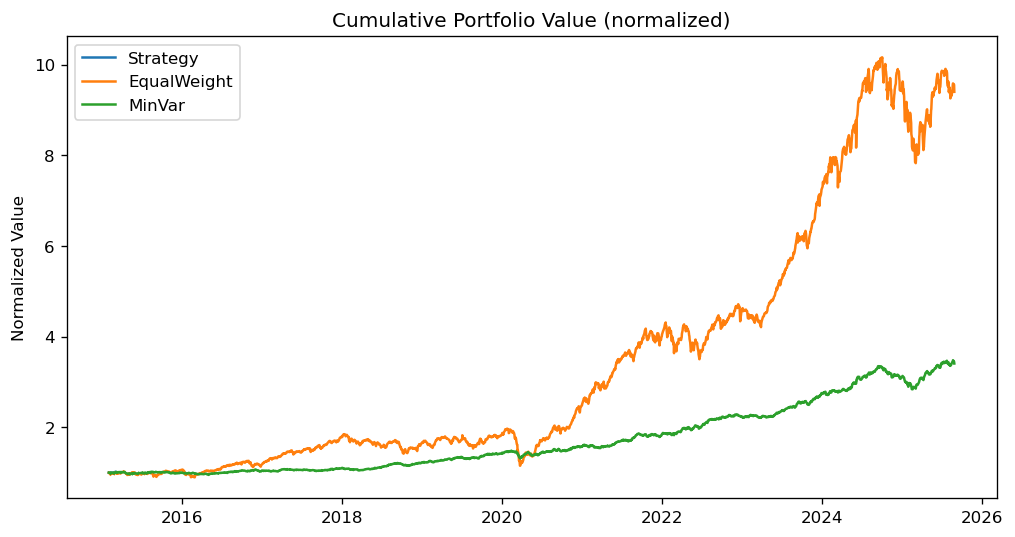

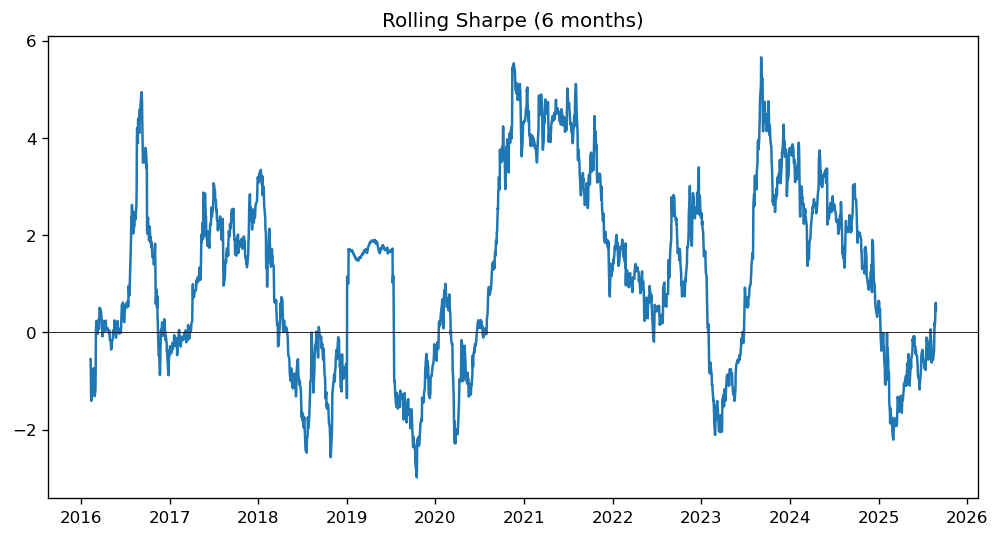

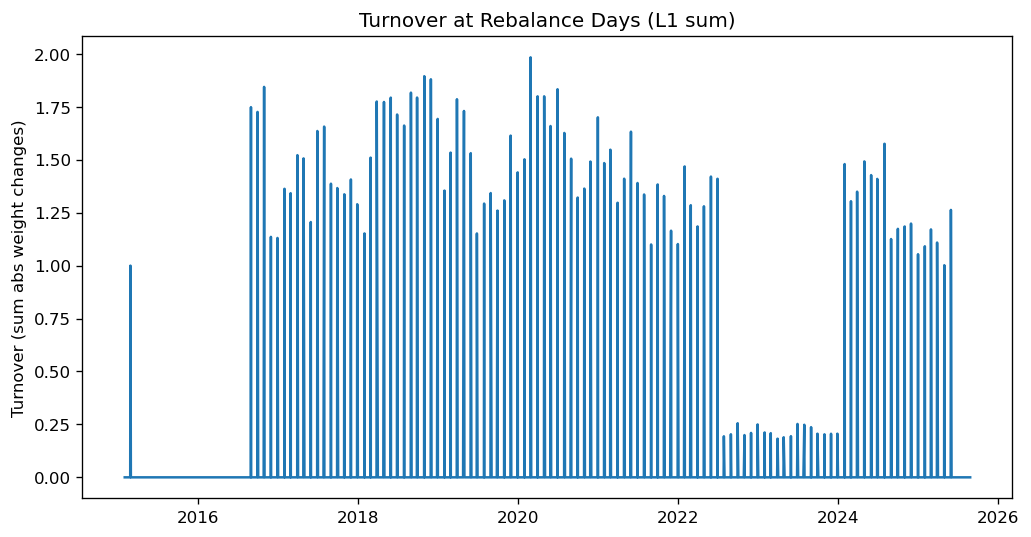

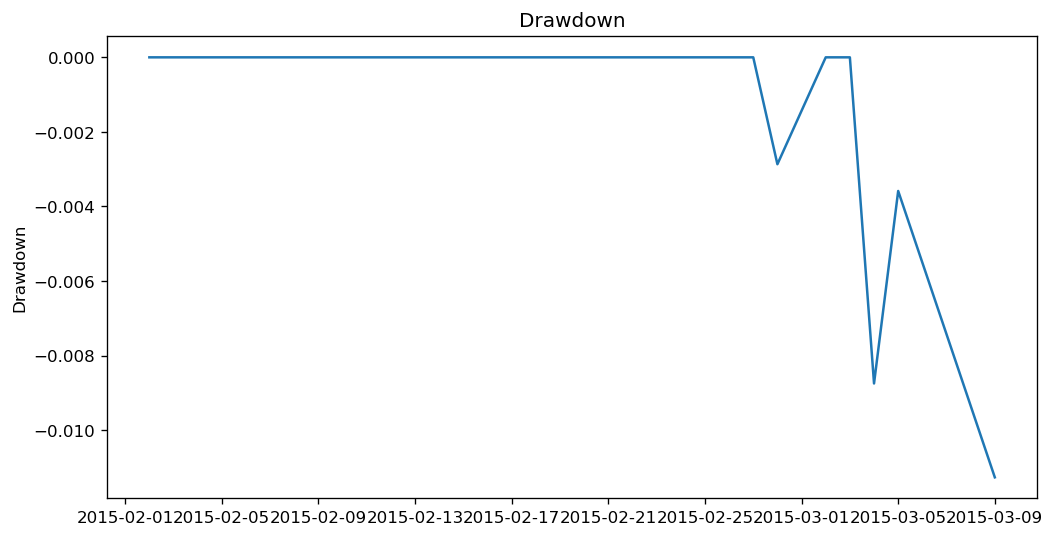

Plots saved to D:\Portfolio Optimzation project\results\backtest


In [11]:
# Cell 11: plots

# cumulative returns series
strategy_cum = pv / pv.iloc[0]
ew_cum = ew_pv / ew_pv.iloc[0]
if has_minvar:
    mv_cum = mv_pv / mv_pv.iloc[0]

plt.figure()
plt.plot(strategy_cum.index, strategy_cum.values, label='Strategy')
plt.plot(ew_cum.index, ew_cum.values, label='EqualWeight')
if has_minvar:
    plt.plot(mv_cum.index, mv_cum.values, label='MinVar')
plt.legend()
plt.title('Cumulative Portfolio Value (normalized)')
plt.ylabel('Normalized Value')
plt.savefig(BACKTEST_DIR / "cumulative_returns.png")
plt.show()

# rolling sharpe (6 months ~ 126 trading days)
rs = rolling_sharpe(pf_returns.fillna(0), window_days=126)
plt.figure()
plt.plot(rs.index, rs.values)
plt.title('Rolling Sharpe (6 months)')
plt.axhline(0, color='k', linewidth=0.5)
plt.savefig(BACKTEST_DIR / "rolling_sharpe.png")
plt.show()

# turnover over time (show rebalance days)
plt.figure()
plt.plot(turnover_daily.index, turnover_daily.values)
plt.title('Turnover at Rebalance Days (L1 sum)')
plt.ylabel('Turnover (sum abs weight changes)')
plt.savefig(BACKTEST_DIR / "turnover.png")
plt.show()

# drawdown curve
cumv = strategy_cum
peak = cumv.cummax()
drawdown = (cumv - peak) / peak
plt.figure()
plt.plot(drawdown.index, drawdown.values)
plt.title('Drawdown')
plt.ylabel('Drawdown')
plt.savefig(BACKTEST_DIR / "drawdown.png")
plt.show()

print("Plots saved to", BACKTEST_DIR)


Cell 12 — Save applied weights (for each rebalance) and final notes

In [12]:
# Cell 12: Save applied weights per rebalance for inspection
weights_out_dir = BACKTEST_DIR / "applied_weights"
os.makedirs(weights_out_dir, exist_ok=True)
for dt, w in applied_weights.items():
    w_df = w.reset_index()
    w_df.columns = ['ticker','weight']
    fname = weights_out_dir / f"weights_{pd.to_datetime(dt).date()}.csv"
    w_df.to_csv(fname, index=False)

print("Saved applied weights to", weights_out_dir)


Saved applied weights to D:\Portfolio Optimzation project\results\backtest\applied_weights


In [13]:
# file location : D:\Portfolio Optimzation project\artifacts\alpha_predictions.csv

alpha_df = pd.read_csv(r"D:\Portfolio Optimzation project\artifacts\alpha_predictions.csv", parse_dates=['date'])

alpha_df['date'].describe()
alpha_df['date'].head(10)
alpha_df['date'].tail(10)

# file location : D:\Portfolio Optimzation project\results\volatility_matrix.csv
vol_df = pd.read_csv(r"D:\Portfolio Optimzation project\results\volatility_matrix.csv", parse_dates=['date'])
print("Alpha unique dates:", alpha_df['date'].nunique())
print("Vol unique dates:", vol_df['date'].nunique())
print("First few alpha dates:", sorted(alpha_df['date'].unique())[:5])
print("First few vol dates:", sorted(vol_df['date'].unique())[:5])


Alpha unique dates: 106
Vol unique dates: 2466
First few alpha dates: [Timestamp('2016-08-31 00:00:00'), Timestamp('2016-09-30 00:00:00'), Timestamp('2016-10-30 00:00:00'), Timestamp('2016-11-30 00:00:00'), Timestamp('2016-12-30 00:00:00')]
First few vol dates: [Timestamp('2015-08-05 00:00:00+0530', tz='UTC+05:30'), Timestamp('2015-08-06 00:00:00+0530', tz='UTC+05:30'), Timestamp('2015-08-07 00:00:00+0530', tz='UTC+05:30'), Timestamp('2015-08-10 00:00:00+0530', tz='UTC+05:30'), Timestamp('2015-08-11 00:00:00+0530', tz='UTC+05:30')]


In [14]:
from pathlib import Path
PORTFOLIO_DIR = Path(r"D:\Portfolio Optimzation project\results\portfolios")

files = sorted(PORTFOLIO_DIR.glob("optimized_weights_*.csv"))
print(f"Found {len(files)} optimized weight files.")
print("Sample:", [f.name for f in files[:5]])


Found 120 optimized weight files.
Sample: ['optimized_weights_2015-09-01.csv', 'optimized_weights_2015-10-01.csv', 'optimized_weights_2015-11-01.csv', 'optimized_weights_2015-12-01.csv', 'optimized_weights_2016-01-01.csv']


In [75]:
import pandas as pd
from pathlib import Path

alpha = pd.read_csv(r"D:\Portfolio Optimzation project\artifacts\alpha_predictions.csv", parse_dates=['date'])
print("Unique dates:", alpha['date'].nunique())
print("Date range:", alpha['date'].min(), "→", alpha['date'].max())
print("Sample rows:")
print(alpha.head())


Unique dates: 106
Date range: 2016-08-31 00:00:00 → 2025-05-30 00:00:00
Sample rows:
        date            ticker  predicted_return
0 2016-08-31     3MINDIA_DAILY          0.023100
1 2016-08-31    AARTIIND_DAILY          0.020570
2 2016-08-31  ABBOTINDIA_DAILY          0.021841
3 2016-08-31         ABB_DAILY          0.021731
4 2016-08-31       ABFRL_DAILY          0.026051
